背景与核心问题：
传统的神经网络在输入信号与神经元激发时序的关系上主要依赖发放率(firing rate)作为编码方式，即以一段时间内的脉冲发放数量（频率）作为特征。这种基于发放率的编码相对粗糙，不考虑精确的脉冲发放时间。而在真实的生物神经系统中，脉冲的精确时序信息（spike timing）往往承载着丰富的信息内涵。研究者希望探索：

使用替代梯度下降学习时，SNN在何种程度上能利用脉冲的时间信息（如脉冲对之间的时间间隔interspike interval, ISI）来提高任务表现？
当我们部分或全部破坏（扰动）时序信息时，模型的性能会如何变化？
是否存在某种过渡现象，从完全利用时序信息到仅依赖发放率的信息，性能如何演变？
基本思想：
举个例子，有一个特定的分类或判别任务，输入是一组神经元脉冲序列，它们的脉冲发放率是x，脉冲间隔（或者更具体地讲，成对脉冲之间的时间差）是y。我们假设如果只用脉冲发放率信息去做任务，模型能达到约60%的正确率。但如果同时利用脉冲的时序信息（即不仅关心有多少次脉冲，也关心脉冲发生的具体时间点及它们之间的时间关系），则可达到接近100%的正确率。

从直观理解：

没有时序信息时，你只知道“这个神经元在这段时间里发了多少脉冲”。
有时序信息时，你还知道“这些脉冲是如何分布在时间轴上的”，例如两个脉冲之间相隔多久，还是两个脉冲是否在几乎同一时间点发放。
进一步的实验设想：

部分破坏时序信息：
将输入脉冲序列中的时序细节进行扰动。例如，定义一个参数f（0 ≤ f ≤ 1）。

当f=0时，保持原有时序信息不变（完整时序信息）。
当f=1时，完全随机化脉冲的出现时间，不留任何原本的时序结构。
随着f从0逐渐增大到1，你可以观察模型性能（正确率）如何变化：

当f接近0时（时序信息丰富）：期望性能接近完整利用时序信息的最高水准，比如接近100%。
当f不断增大，时序信息逐渐破坏，只剩下较为随机化的脉冲时间分布，那么模型的性能可能逐渐下降。最终在f=1（无时序信息）时，只剩下基于脉冲计数或者发放率的信息，性能可能回落到“仅靠发放率”的水准（例如60%）。
IS码(间隔编码)与同步编码：
除了将信息编码在脉冲间隔（ISI）中，还可以尝试其他编码方式。例如，在某些神经元团簇中，如果一组神经元在几乎相同的时间内同时发脉冲，那么这一“神经元簇同时发放事件（coincidence code）”本身可能具有信息意义。对模型而言，可以尝试破坏这种同步发放的精准时间关系，观察性能下降的程度。

更自然的刺激和数据集：
作者还提到将这些概念扩展到更真实的输入数据。例如，从Neuro4ML数据集或其他生物启发的声音数据集中获取脉冲发放作为输入，并尝试将脉冲时间进行扰动来分析性能变化。这有助于了解模型在更自然、更复杂刺激条件下对时序信息的敏感度。

实验预期与研究方向：

当我们逐渐扰乱时序信息，从完全保留到完全随机化，可以绘制出性能随f的变化曲线。
这将揭示模型在学习过程中对时序信息的依赖程度。
若发现模型的性能在f接近0时远高于仅用发放率时的水平，说明模型通过替代梯度下降确实学会了利用时序信息。
若在增加f的过程中性能很快下降，则说明模型对精准的时序依赖较强，时序信息是其区分度的关键。若性能下降较为平缓，可能说明模型从时序和发放率中同时提取信息，或对时序扰动不敏感。
后续研究与分析：

一旦确定了替代梯度下降的方法能够（或不能）有效利用时序信息，将进一步探讨为什么会出现这种现象。
可以考察模型学习到的参数结构，以及其对输入数据统计特性的敏感度。
探究训练的稳定性：当学习利用时序信息时，模型参数更新是否容易出现震荡或过拟合？
尝试和理论上的理想情况或解析解做比较：若已有某些已知的解析方法能准确利用时序信息，那么与替代梯度下降的性能对比就能告诉我们目前的训练策略是否足够高效或还需改进。
总而言之，导师这段话的核心是在引导一种研究思路：通过控制时序信息的完整度来研究SNN在替代梯度下降训练下对时序信息的敏感度和利用程度，从而更好地理解SNN中时间编码与学习机制。这将为后续在更复杂任务中应用SNN提供有价值的理论与实证依据。

Step 1: Simulated Data Generation

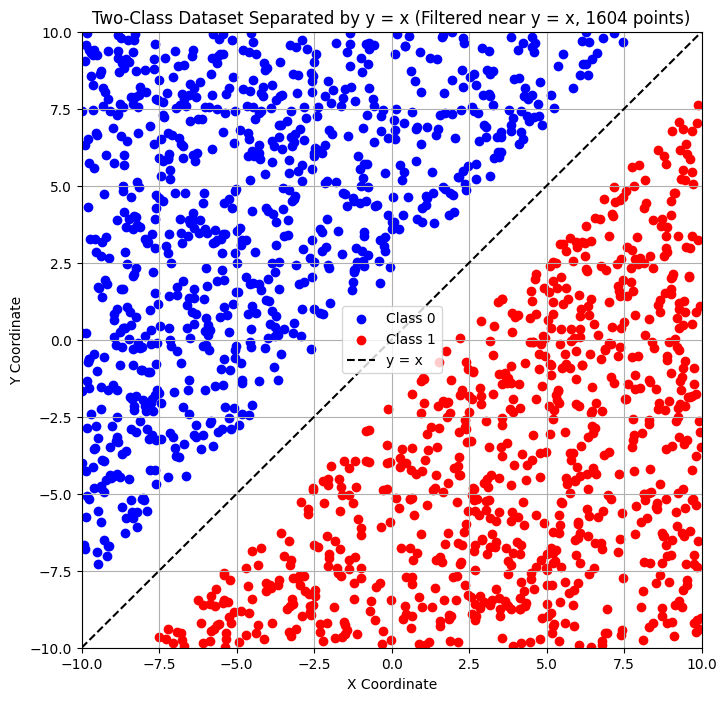

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Number of points per class
num_points = 2000  # Increase if you want more total points
radius = 10        # half side of the square [-10,10]x[-10,10]
min_distance = 1.5   # Minimum distance threshold from the line y = x

# 1. Generate random points within a square [-radius, radius]^2
X = np.random.uniform(low=-radius, high=radius, size=(num_points, 2))

# 2. Compute the distance of points to the line y = x
distances = np.abs(X[:, 1] - X[:, 0]) / np.sqrt(2)

# 3. Filter points that satisfy the distance condition
valid_indices = distances >= min_distance
X = X[valid_indices]
num_valid_points = X.shape[0]

# 4. Classify points based on y = x
y = np.where(X[:, 1] > X[:, 0], 0, 1)  # Class 0 if y>x, else Class 1

# 5. Visualize the generated data
plt.figure(figsize=(8, 8))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')

# plot line y=x
plt.plot([-radius, radius], [-radius, radius], color='black', linestyle='--', label='y = x')

plt.xlim(-radius, radius)
plt.ylim(-radius, radius)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Two-Class Dataset Separated by y = x (Filtered near y = x, {num_valid_points} points)')
plt.legend()
plt.grid()
plt.show()


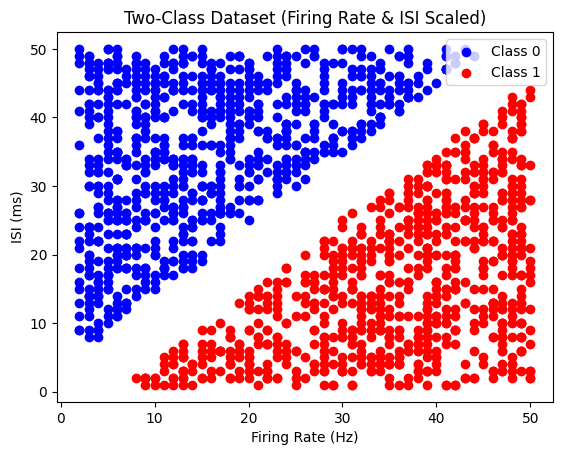

Spike Trains Shape: (1604, 10, 500)
Randomly selected Class 0 index: [1031  830  250  860  280]


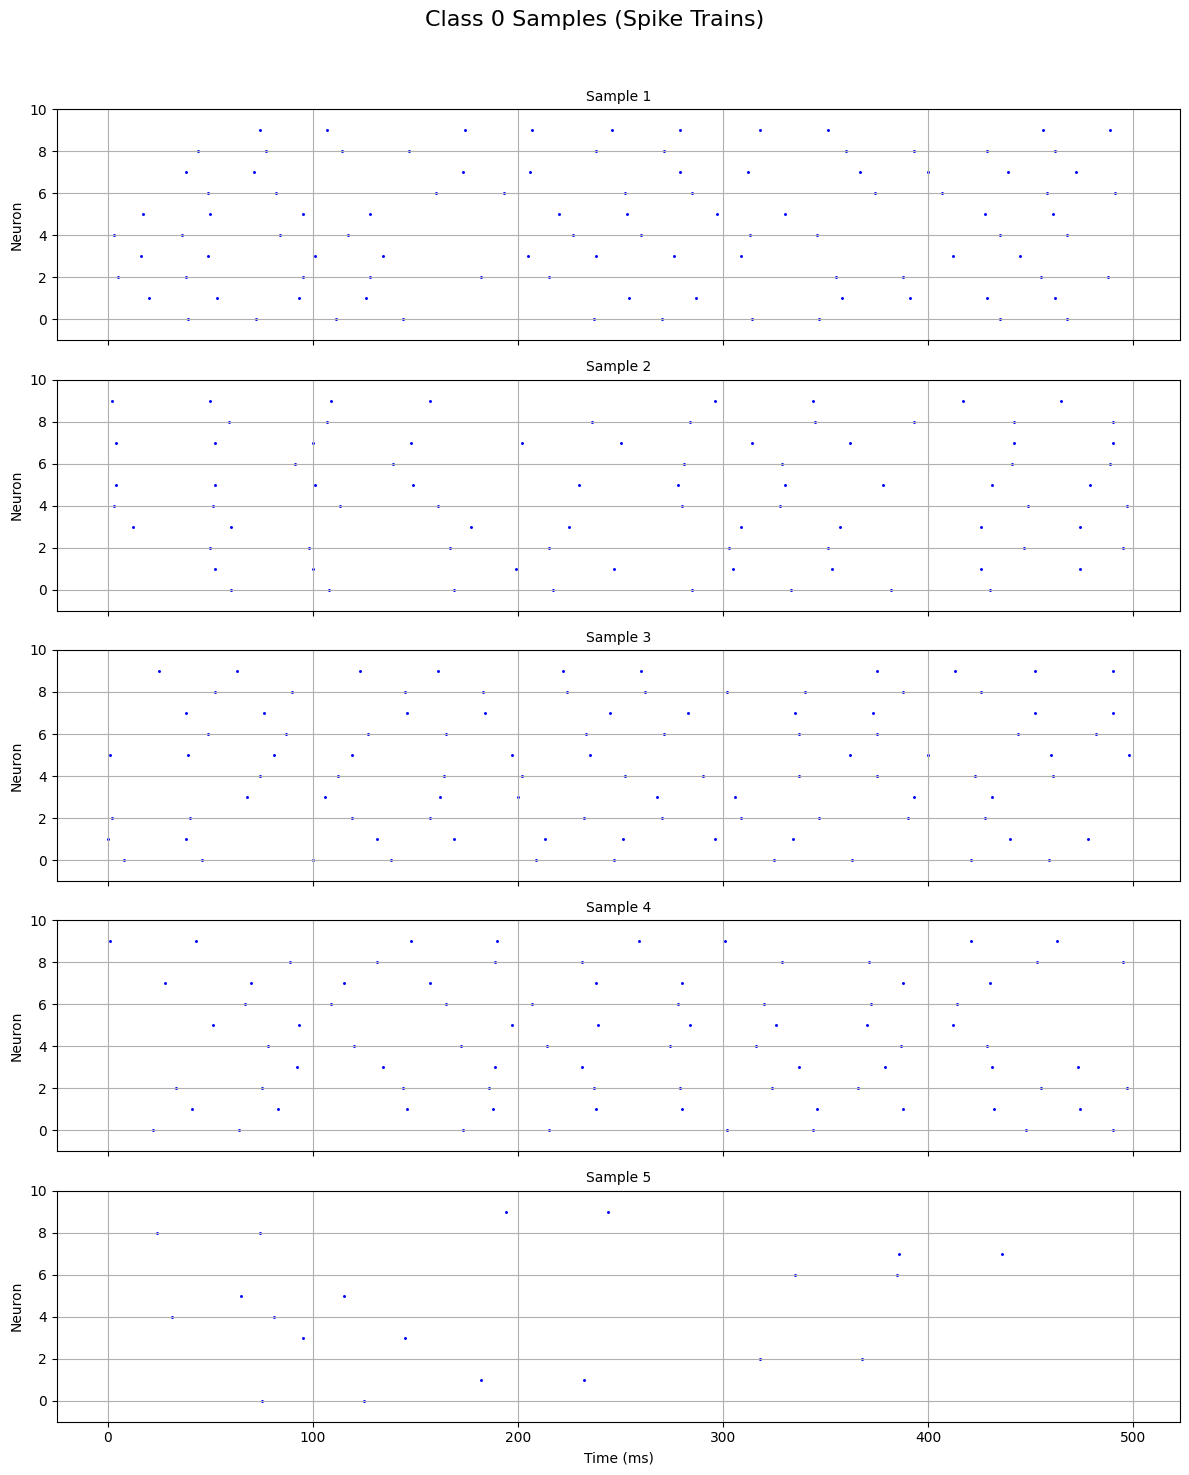

Randomly selected Class 0 index: [1580 1592  320  279 1302]


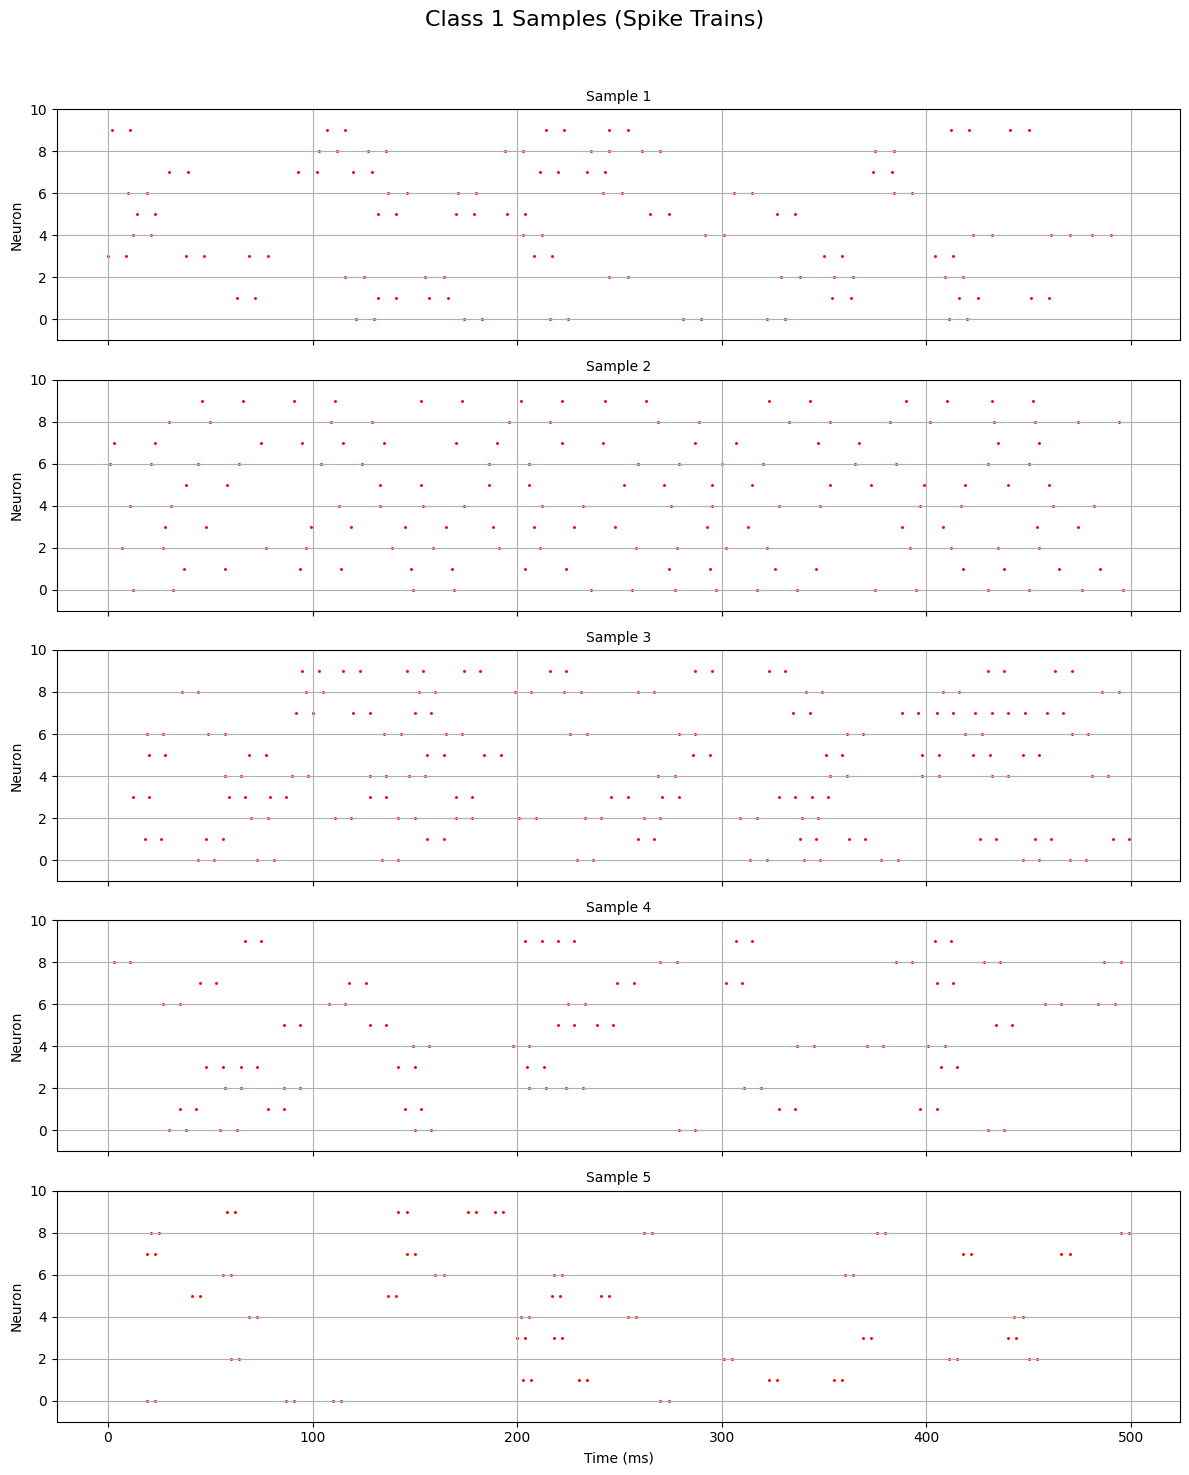

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Number of points per class
num_points = 2000  # Increase the number of points to ensure sufficient data after filtering
radius = 10        # Radius of the circle
min_distance = 1.5   # Minimum distance threshold from the line y = x

# 1. Generate random points within a square [-radius, radius]^2
X = np.random.uniform(low=-radius, high=radius, size=(num_points, 2))

# 2. Compute the distance of points to the line y = x
distances = np.abs(X[:, 1] - X[:, 0]) / np.sqrt(2)

# Filter points that satisfy the distance condition
valid_indices = distances >= min_distance
X = X[valid_indices]
num_valid_points = X.shape[0]

# Map to the integer coordinate range
def linear_map_to_integer(value, old_min, old_max, new_min, new_max):
    mapped = np.round((value - old_min) / (old_max - old_min) * (new_max - new_min) + new_min)
    return np.clip(mapped, new_min, new_max).astype(int)

# Map to specified ranges: firing rate [1, 50] Hz and ISI [1, 50] ms
X_min = X.min(axis=0)
X_max = X.max(axis=0)
firing_rates = linear_map_to_integer(X[:, 0], X_min[0], X_max[0], 2, 50)  # Hz
isis = linear_map_to_integer(X[:, 1], X_min[1], X_max[1], 1, 50)          # ms

# Visualize the data distribution in the mapped range
plt.scatter(firing_rates[y == 0], isis[y == 0], color='blue', label='Class 0')
plt.scatter(firing_rates[y == 1], isis[y == 1], color='red', label='Class 1')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('ISI (ms)')
plt.legend()
plt.title('Two-Class Dataset (Firing Rate & ISI Scaled)')
plt.show()

# T=100ms, 0.1 second, 100 time steps (1ms per step)
T = 500
num_neurons = 10

# Function to generate spike trains
def generate_spike_train(f, isi, num_neurons, T=100, max_attempts=50):
    """
    Generate spike trains based on firing rate (Hz) and ISI (ms).
    Each data point generates spike trains for num_neurons neurons with the same firing rate and ISI.
    """
    spike_trains = np.zeros((num_neurons, T), dtype=int)  # [num_neurons, T]

    for neuron_idx in range(num_neurons):
        total_spikes = int(round(f) * T / 1000)
        if total_spikes % 2 != 0:
            total_spikes += 1  # Ensure an even number of spikes

        pairs = total_spikes // 2
        isi_steps = max(1, int(round(isi)))  # Ensure isi_steps >= 1

        # Record occupied time steps
        occupied_times = set()

        for _ in range(pairs):
            placed = False
            for _ in range(max_attempts):
                # Candidate time steps: no conflict with occupied time steps
                start_t = np.random.randint(0, T - isi_steps)
                if all(t not in occupied_times for t in range(start_t - isi_steps, start_t + isi_steps)):
                    # Place spike pair
                    spike_trains[neuron_idx, start_t] = 1
                    spike_trains[neuron_idx, start_t + isi_steps] = 1

                    # Update occupied time steps
                    occupied_times.update([start_t - isi_steps, start_t + isi_steps])
                    placed = True
                    break

            if not placed:
                continue  # Skip the pair if placement fails
    return spike_trains

# Generate spike trains for each data point
spike_trains_per_sample = []  # Each data point generates a set of spike trains
for i in range(len(firing_rates)):
    f_val = firing_rates[i]
    isi_val = isis[i]
    spike_trains = generate_spike_train(f_val, isi_val, num_neurons, T=T)
    spike_trains_per_sample.append(spike_trains)

spike_trains_per_sample = np.array(spike_trains_per_sample)  # [N, num_neurons, T]
print(f"Spike Trains Shape: {spike_trains_per_sample.shape}")

# Randomly select a Class 0 and Class 1 data point for visualization
class0_indices = np.where(y == 0)[0]  # All indices for Class 0
class1_indices = np.where(y == 1)[0]  # All indices for Class 1

# Visualize spike trains for Class 0 data point
num_samples_to_plot = 5

fig, axes = plt.subplots(num_samples_to_plot, 1, figsize=(12, num_samples_to_plot * 3), sharex=True)
fig.suptitle('Class 0 Samples (Spike Trains)', fontsize=16)

selected_class0_indices = np.random.choice(class0_indices, size=num_samples_to_plot, replace=False)
print(f"Randomly selected Class 0 index: {selected_class0_indices}")

for i, (class0_idx, ax) in enumerate(zip(selected_class0_indices, axes)):
    example_neuron_spikes_class0 = spike_trains_per_sample[class0_idx]

    for neuron_idx in range(num_neurons):
        spike_times = np.where(example_neuron_spikes_class0[neuron_idx] == 1)[0]
        ax.scatter(spike_times, np.ones_like(spike_times) * neuron_idx, s=5, color='b', marker='.')

    ax.set_ylabel('Neuron')
    ax.set_title(f'Sample {i+1}', fontsize=10)
    ax.set_ylim(-1, num_neurons)
    ax.grid(True)

axes[-1].set_xlabel('Time (ms)')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局避免标题遮挡
plt.show()


# Visualize spike trains for Class 1 data point
fig, axes = plt.subplots(num_samples_to_plot, 1, figsize=(12, num_samples_to_plot * 3), sharex=True)
fig.suptitle('Class 1 Samples (Spike Trains)', fontsize=16)

selected_class1_indices = np.random.choice(class1_indices, size=num_samples_to_plot, replace=False)
print(f"Randomly selected Class 0 index: {selected_class1_indices}")

for i, (class1_idx, ax) in enumerate(zip(selected_class1_indices, axes)):
    example_neuron_spikes_class1 = spike_trains_per_sample[class1_idx]

    for neuron_idx in range(num_neurons):
        spike_times = np.where(example_neuron_spikes_class1[neuron_idx] == 1)[0]
        ax.scatter(spike_times, np.ones_like(spike_times) * neuron_idx, s=5, color='r', marker='.')

    ax.set_ylabel('Neuron')
    ax.set_title(f'Sample {i+1}', fontsize=10)
    ax.set_ylim(-1, num_neurons)
    ax.grid(True)

axes[-1].set_xlabel('Time (ms)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Step 2: Build the Spiking Neural Network Model (SNN)

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import snntorch as snn
import snntorch.functional as SF

from snntorch import surrogate
# Data shape: spike_trains [N, num_neurons, T], y [N]
class SpikeDataset(Dataset):
    def __init__(self, spike_trains, labels):
        self.spike_trains = spike_trains  # [N, num_neurons, T]
        self.labels = labels  # [N]

    def __len__(self):
        return len(self.spike_trains)

    def __getitem__(self, idx):
        st = self.spike_trains[idx]  # Single sample [num_neurons, T]
        lbl = self.labels[idx]
        st = torch.tensor(st, dtype=torch.float32)  # Convert to Tensor
        lbl = torch.tensor(lbl, dtype=torch.long)
        return st, lbl


# Split dataset
N = len(spike_trains_per_sample)
print(f"Total number of samples: {N}")

# Ensure firing_rates and isis match spike_trains and y
firing_rates = np.array(firing_rates)  # Convert to numpy array
isis = np.array(isis)  # Convert to numpy array
y = np.array(y)  # Label array

# Shuffle all data uniformly
indices = np.arange(N)
np.random.shuffle(indices)

spike_trains = np.array(spike_trains_per_sample)[indices]  # Shuffled spike trains
y = y[indices]  # Shuffled labels
firing_rates = firing_rates[indices]  # Shuffled firing rates
isis = isis[indices]  # Shuffled ISI

# Split into training and testing sets
split = int(0.7 * N)
train_indices = indices[:split]  # Training set indices
test_indices = indices[split:]   # Testing set indices

train_st, test_st = spike_trains[:split], spike_trains[split:]
train_lbl, test_lbl = y[:split], y[split:]

train_firing_rates, test_firing_rates = firing_rates[:split], firing_rates[split:]
train_isis, test_isis = isis[:split], isis[split:]

train_dataset = SpikeDataset(train_st, train_lbl)
test_dataset = SpikeDataset(test_st, test_lbl)


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model parameters
num_neurons = 10  # Each sample contains 10 neurons
num_hidden = 64
num_outputs = 2  # Number of classes
T = 500
beta = 0.9

spike_grad = surrogate.fast_sigmoid(slope=25)  # Slope controls curve smoothness


# Define SNN Model
class DeeperSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_neurons, 64)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.fc2 = nn.Linear(64, 64)   # 新增隐藏层
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.fc3 = nn.Linear(64, num_outputs)  # Non-spiking output layer
        self.lif3 = snn.Leaky(beta=beta, spike_grad=None)

    def forward(self, x):
        # x: [batch, num_neurons, T]
        x = x.permute(2, 0, 1)  # [T, batch, num_neurons]
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        mem_output = self.lif3.init_leaky()  # 初始化膜电位
        for t in range(T):
            cur1 = self.fc1(x[t])
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            _, mem_output = self.lif3(cur3, mem_output)  # 膜电位随时间泄漏
            #print(mem_output)

        return mem_output  # 最终膜电位用于分类


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = DeeperSNN().to(device)

# Training configuration
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

def compute_accuracy(outputs, targets):
    _, preds = outputs.max(1)
    correct = (preds == targets).float().sum().item()
    return correct / targets.size(0)

# Training and testing
num_epochs = 50
for epoch in range(num_epochs):
    net.train()
    train_loss, train_acc = 0.0, 0.0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = net(data)  # Membrane potentials (no spikes)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_accuracy(outputs, targets)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # Evaluation
    net.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = net(data)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            test_acc += compute_accuracy(outputs, targets)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2%}")


Total number of samples: 1604
Epoch 1/50, Train Loss: 0.6769, Train Acc: 59.68%, Test Loss: 0.6253, Test Acc: 68.75%
Epoch 2/50, Train Loss: 0.5819, Train Acc: 70.07%, Test Loss: 0.5489, Test Acc: 73.19%
Epoch 3/50, Train Loss: 0.5670, Train Acc: 72.80%, Test Loss: 0.5147, Test Acc: 74.40%


KeyboardInterrupt: 

Step 3: Performance Evaluation

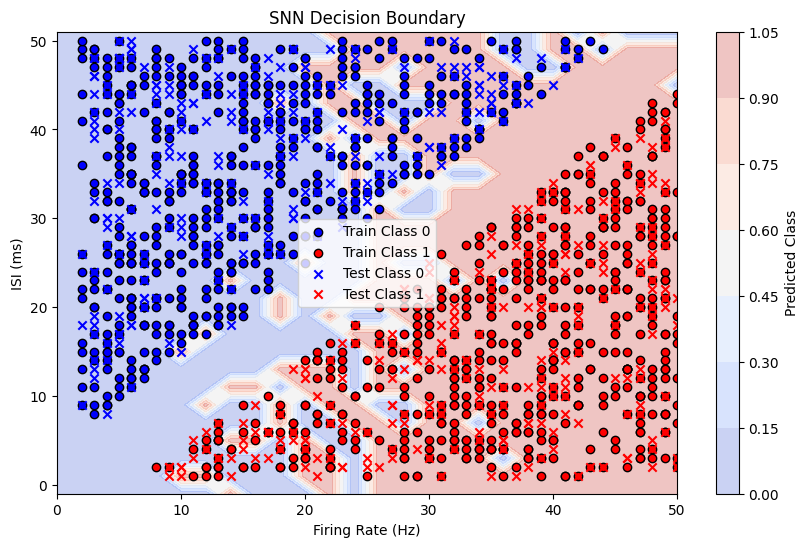

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset

# Generate grid data points
def generate_grid(x_min, x_max, y_min, y_max, step_size=0.5):
    """
    Generate grid points within the range of firing rate and ISI.
    """
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                         np.arange(y_min, y_max, step_size))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, grid_points

# Convert grid points into spike trains
def generate_spike_train_from_grid(grid_points, num_neurons, T=500, max_attempts=50):
    """
    Generate corresponding spike trains based on grid points' firing rates and ISIs.
    Each point generates num_neurons neurons, with identical firing rate and ISI for all neurons.
    """
    n_points = len(grid_points)
    spike_trains = np.zeros((n_points, num_neurons, T), dtype=int)  # [n_points, num_neurons, T]

    for i, (firing_rate, isi) in enumerate(grid_points):
        for neuron_idx in range(num_neurons):
            total_spikes = int(round(firing_rate) * T / 1000)
            if total_spikes % 2 != 0:
                total_spikes += 1  # Ensure the spike count is even

            pairs = total_spikes // 2
            isi_steps = max(1, int(round(isi)))  # Ensure isi_steps >= 1

            # Track occupied time steps
            occupied_times = set()

            for _ in range(pairs):
                placed = False
                for _ in range(max_attempts):
                    # Candidate time step: ensure no overlap with occupied times
                    start_t = np.random.randint(0, T - isi_steps)
                    if all(t not in occupied_times for t in range(start_t, start_t + isi_steps + 1)):
                        # Place spike pair
                        spike_trains[i, neuron_idx, start_t] = 1
                        spike_trains[i, neuron_idx, start_t + isi_steps] = 1

                        # Update occupied times to avoid overlapping spike pairs
                        occupied_times.update(range(start_t, start_t + isi_steps + 1))
                        placed = True
                        break

                if not placed:
                    continue  # Skip the pair if it cannot be placed

    return spike_trains


# Predict labels for grid points
def predict_grid_labels(net, device, grid_spike_trains, T, batch_size=256):
    """
    Classify generated spike trains for grid points.
    """
    net.eval()
    dataset = TensorDataset(torch.tensor(grid_spike_trains, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    predictions = []

    with torch.no_grad():
        for (data,) in loader:
            data = data.to(device)  # shape [batch, num_neurons, T]
            outputs = net(data)     # 调用 forward()，返回 [batch, num_outputs]
            _, preds = outputs.max(1)
            predictions.extend(preds.cpu().numpy())

    return np.array(predictions)

# Visualize decision boundary
def visualize_decision_boundary(net, device, train_indices, test_indices, firing_rates, isis, y, step_size=2, T=500, num_neurons=50):
    """
    Visualize the SNN decision boundary using generated spike trains.
    """
    # 1. Define grid range
    x_min, x_max = firing_rates.min() - 2, firing_rates.max() + 2
    y_min, y_max = isis.min() - 2, isis.max() + 2
    xx, yy, grid_points = generate_grid(x_min, x_max, y_min, y_max, step_size)

    # 2. Generate spike trains for grid points
    grid_spike_trains = generate_spike_train_from_grid(grid_points, num_neurons, T)

    # 3. Classify grid points
    predictions = predict_grid_labels(net, device, grid_spike_trains, T)
    predictions = predictions.reshape(xx.shape)

    # 4. Visualize classification regions
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, predictions, alpha=0.3, cmap='coolwarm')
    plt.colorbar(label='Predicted Class')

    # Overlay training set points
    plt.scatter(firing_rates[train_indices][y[train_indices] == 0],
                isis[train_indices][y[train_indices] == 0], color='blue', label='Train Class 0', edgecolor='k')
    plt.scatter(firing_rates[train_indices][y[train_indices] == 1],
                isis[train_indices][y[train_indices] == 1], color='red', label='Train Class 1', edgecolor='k')

    # Overlay testing set points
    plt.scatter(firing_rates[test_indices][y[test_indices] == 0],
                isis[test_indices][y[test_indices] == 0], color='blue', marker='x', label='Test Class 0')
    plt.scatter(firing_rates[test_indices][y[test_indices] == 1],
                isis[test_indices][y[test_indices] == 1], color='red', marker='x', label='Test Class 1')

    plt.xlabel('Firing Rate (Hz)')
    plt.ylabel('ISI (ms)')
    plt.title('SNN Decision Boundary')
    plt.legend()
    plt.show()

visualize_decision_boundary(net, device, train_indices, test_indices, firing_rates, isis, y, step_size=2, T=500, num_neurons=10)


Try other parameters...

In [31]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import snntorch as snn
import snntorch.functional as SF

from snntorch import surrogate
# Data shape: spike_trains [N, num_neurons, T], y [N]
class SpikeDataset(Dataset):
    def __init__(self, spike_trains, labels):
        self.spike_trains = spike_trains  # [N, num_neurons, T]
        self.labels = labels  # [N]

    def __len__(self):
        return len(self.spike_trains)

    def __getitem__(self, idx):
        st = self.spike_trains[idx]  # Single sample [num_neurons, T]
        lbl = self.labels[idx]
        st = torch.tensor(st, dtype=torch.float32)  # Convert to Tensor
        lbl = torch.tensor(lbl, dtype=torch.long)
        return st, lbl


# Split dataset
N = len(spike_trains_per_sample)
print(f"Total number of samples: {N}")

# Ensure firing_rates and isis match spike_trains and y
firing_rates = np.array(firing_rates)  # Convert to numpy array
isis = np.array(isis)  # Convert to numpy array
y = np.array(y)  # Label array

# Shuffle all data uniformly
indices = np.arange(N)
np.random.shuffle(indices)

spike_trains = np.array(spike_trains_per_sample)[indices]  # Shuffled spike trains
y = y[indices]  # Shuffled labels
firing_rates = firing_rates[indices]  # Shuffled firing rates
isis = isis[indices]  # Shuffled ISI

# Split into training and testing sets
split = int(0.7 * N)
train_indices = indices[:split]  # Training set indices
test_indices = indices[split:]   # Testing set indices

train_st, test_st = spike_trains[:split], spike_trains[split:]
train_lbl, test_lbl = y[:split], y[split:]

train_firing_rates, test_firing_rates = firing_rates[:split], firing_rates[split:]
train_isis, test_isis = isis[:split], isis[split:]

train_dataset = SpikeDataset(train_st, train_lbl)
test_dataset = SpikeDataset(test_st, test_lbl)


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model parameters
num_neurons = 10  # Each sample contains 10 neurons
num_hidden = 64
num_outputs = 2  # Number of classes
T = 500
beta = 0.9

spike_grad = surrogate.fast_sigmoid(slope=25)  # Slope controls curve smoothness


# Define SNN Model
class DeeperSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_neurons, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.fc2 = nn.Linear(num_hidden, num_hidden)   # 新增隐藏层
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.fc3 = nn.Linear(num_hidden, num_outputs)  # Non-spiking output layer
        self.lif3 = snn.Leaky(beta=beta, spike_grad=None)

    def forward(self, x):
        # x: [batch, num_neurons, T]
        x = x.permute(2, 0, 1)  # [T, batch, num_neurons]
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        mem_output = self.lif3.init_leaky()  # 初始化膜电位
        for t in range(T):
            cur1 = self.fc1(x[t])
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            _, mem_output = self.lif3(cur3, mem_output)  # 膜电位随时间泄漏
            #print(mem_output)

        return mem_output  # 最终膜电位用于分类


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = DeeperSNN().to(device)

# Training configuration
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

def compute_accuracy(outputs, targets):
    _, preds = outputs.max(1)
    correct = (preds == targets).float().sum().item()
    return correct / targets.size(0)

# Training and testing
num_epochs = 50
for epoch in range(num_epochs):
    net.train()
    train_loss, train_acc = 0.0, 0.0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = net(data)  # Membrane potentials (no spikes)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_accuracy(outputs, targets)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # Evaluation
    net.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = net(data)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            test_acc += compute_accuracy(outputs, targets)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2%}")


Total number of samples: 1604
Epoch 1/50, Train Loss: 0.6644, Train Acc: 65.40%, Test Loss: 0.5138, Test Acc: 78.63%
Epoch 2/50, Train Loss: 0.5354, Train Acc: 75.53%, Test Loss: 0.5061, Test Acc: 76.61%
Epoch 3/50, Train Loss: 0.5245, Train Acc: 76.58%, Test Loss: 0.4662, Test Acc: 79.44%
Epoch 4/50, Train Loss: 0.4586, Train Acc: 80.72%, Test Loss: 0.4460, Test Acc: 81.25%
Epoch 5/50, Train Loss: 0.4686, Train Acc: 78.08%, Test Loss: 0.4689, Test Acc: 81.05%
Epoch 6/50, Train Loss: 0.4580, Train Acc: 78.43%, Test Loss: 0.4333, Test Acc: 80.44%
Epoch 7/50, Train Loss: 0.4533, Train Acc: 79.49%, Test Loss: 0.4412, Test Acc: 80.65%
Epoch 8/50, Train Loss: 0.4388, Train Acc: 79.75%, Test Loss: 0.4605, Test Acc: 76.41%
Epoch 9/50, Train Loss: 0.4535, Train Acc: 80.81%, Test Loss: 0.4318, Test Acc: 77.42%
Epoch 10/50, Train Loss: 0.4335, Train Acc: 80.63%, Test Loss: 0.4257, Test Acc: 82.06%
Epoch 11/50, Train Loss: 0.4085, Train Acc: 81.25%, Test Loss: 0.4431, Test Acc: 79.84%
Epoch 12/50

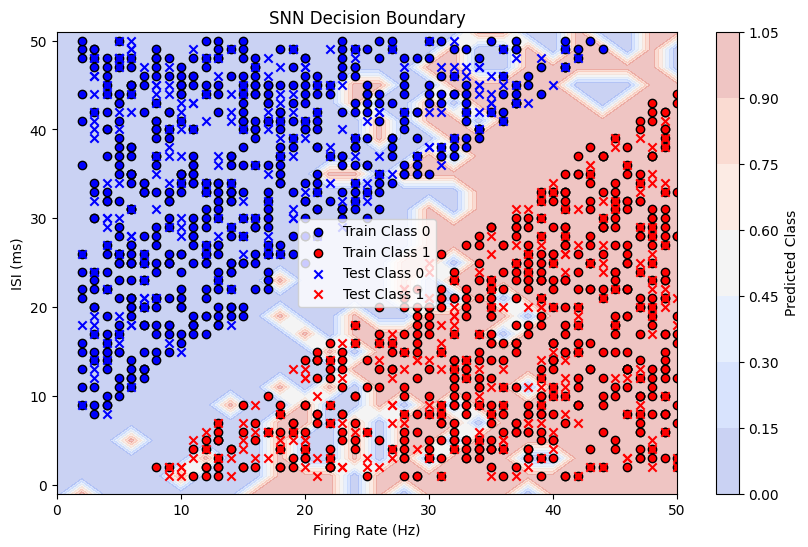

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset

# Generate grid data points
def generate_grid(x_min, x_max, y_min, y_max, step_size=0.5):
    """
    Generate grid points within the range of firing rate and ISI.
    """
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                         np.arange(y_min, y_max, step_size))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, grid_points

# Convert grid points into spike trains
def generate_spike_train_from_grid(grid_points, num_neurons, T=500, max_attempts=50):
    """
    Generate corresponding spike trains based on grid points' firing rates and ISIs.
    Each point generates num_neurons neurons, with identical firing rate and ISI for all neurons.
    """
    n_points = len(grid_points)
    spike_trains = np.zeros((n_points, num_neurons, T), dtype=int)  # [n_points, num_neurons, T]

    for i, (firing_rate, isi) in enumerate(grid_points):
        for neuron_idx in range(num_neurons):
            total_spikes = int(round(firing_rate) * T / 1000)
            if total_spikes % 2 != 0:
                total_spikes += 1  # Ensure the spike count is even

            pairs = total_spikes // 2
            isi_steps = max(1, int(round(isi)))  # Ensure isi_steps >= 1

            # Track occupied time steps
            occupied_times = set()

            for _ in range(pairs):
                placed = False
                for _ in range(max_attempts):
                    # Candidate time step: ensure no overlap with occupied times
                    start_t = np.random.randint(0, T - isi_steps)
                    if all(t not in occupied_times for t in range(start_t, start_t + isi_steps + 1)):
                        # Place spike pair
                        spike_trains[i, neuron_idx, start_t] = 1
                        spike_trains[i, neuron_idx, start_t + isi_steps] = 1

                        # Update occupied times to avoid overlapping spike pairs
                        occupied_times.update(range(start_t, start_t + isi_steps + 1))
                        placed = True
                        break

                if not placed:
                    continue  # Skip the pair if it cannot be placed

    return spike_trains


# Predict labels for grid points
def predict_grid_labels(net, device, grid_spike_trains, T, batch_size=256):
    """
    Classify generated spike trains for grid points.
    """
    net.eval()
    dataset = TensorDataset(torch.tensor(grid_spike_trains, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    predictions = []

    with torch.no_grad():
        for (data,) in loader:
            data = data.to(device)  # shape [batch, num_neurons, T]
            outputs = net(data)     # 调用 forward()，返回 [batch, num_outputs]
            _, preds = outputs.max(1)
            predictions.extend(preds.cpu().numpy())

    return np.array(predictions)

# Visualize decision boundary
def visualize_decision_boundary(net, device, train_indices, test_indices, firing_rates, isis, y, step_size=2, T=500, num_neurons=50):
    """
    Visualize the SNN decision boundary using generated spike trains.
    """
    # 1. Define grid range
    x_min, x_max = firing_rates.min() - 2, firing_rates.max() + 2
    y_min, y_max = isis.min() - 2, isis.max() + 2
    xx, yy, grid_points = generate_grid(x_min, x_max, y_min, y_max, step_size)

    # 2. Generate spike trains for grid points
    grid_spike_trains = generate_spike_train_from_grid(grid_points, num_neurons, T)

    # 3. Classify grid points
    predictions = predict_grid_labels(net, device, grid_spike_trains, T)
    predictions = predictions.reshape(xx.shape)

    # 4. Visualize classification regions
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, predictions, alpha=0.3, cmap='coolwarm')
    plt.colorbar(label='Predicted Class')

    # Overlay training set points
    plt.scatter(firing_rates[train_indices][y[train_indices] == 0],
                isis[train_indices][y[train_indices] == 0], color='blue', label='Train Class 0', edgecolor='k')
    plt.scatter(firing_rates[train_indices][y[train_indices] == 1],
                isis[train_indices][y[train_indices] == 1], color='red', label='Train Class 1', edgecolor='k')

    # Overlay testing set points
    plt.scatter(firing_rates[test_indices][y[test_indices] == 0],
                isis[test_indices][y[test_indices] == 0], color='blue', marker='x', label='Test Class 0')
    plt.scatter(firing_rates[test_indices][y[test_indices] == 1],
                isis[test_indices][y[test_indices] == 1], color='red', marker='x', label='Test Class 1')

    plt.xlabel('Firing Rate (Hz)')
    plt.ylabel('ISI (ms)')
    plt.title('SNN Decision Boundary')
    plt.legend()
    plt.show()

visualize_decision_boundary(net, device, train_indices, test_indices, firing_rates, isis, y, step_size=2, T=500, num_neurons=10)

In [37]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import snntorch as snn
import snntorch.functional as SF

from snntorch import surrogate
# Data shape: spike_trains [N, num_neurons, T], y [N]
class SpikeDataset(Dataset):
    def __init__(self, spike_trains, labels):
        self.spike_trains = spike_trains  # [N, num_neurons, T]
        self.labels = labels  # [N]

    def __len__(self):
        return len(self.spike_trains)

    def __getitem__(self, idx):
        st = self.spike_trains[idx]  # Single sample [num_neurons, T]
        lbl = self.labels[idx]
        st = torch.tensor(st, dtype=torch.float32)  # Convert to Tensor
        lbl = torch.tensor(lbl, dtype=torch.long)
        return st, lbl


# Split dataset
N = len(spike_trains_per_sample)
print(f"Total number of samples: {N}")

# Ensure firing_rates and isis match spike_trains and y
firing_rates = np.array(firing_rates)  # Convert to numpy array
isis = np.array(isis)  # Convert to numpy array
y = np.array(y)  # Label array

# Shuffle all data uniformly
indices = np.arange(N)
np.random.shuffle(indices)

spike_trains = np.array(spike_trains_per_sample)[indices]  # Shuffled spike trains
y = y[indices]  # Shuffled labels
firing_rates = firing_rates[indices]  # Shuffled firing rates
isis = isis[indices]  # Shuffled ISI

# Split into training and testing sets
split = int(0.7 * N)
train_indices = indices[:split]  # Training set indices
test_indices = indices[split:]   # Testing set indices

train_st, test_st = spike_trains[:split], spike_trains[split:]
train_lbl, test_lbl = y[:split], y[split:]

train_firing_rates, test_firing_rates = firing_rates[:split], firing_rates[split:]
train_isis, test_isis = isis[:split], isis[split:]

train_dataset = SpikeDataset(train_st, train_lbl)
test_dataset = SpikeDataset(test_st, test_lbl)


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model parameters
num_neurons = 10  # Each sample contains 10 neurons
num_hidden = 128
num_outputs = 2  # Number of classes
T = 500
beta = 0.9

spike_grad = surrogate.fast_sigmoid(slope=25)  # Slope controls curve smoothness


# Define SNN Model
class DeeperSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_neurons, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.fc2 = nn.Linear(num_hidden, num_hidden)   # 新增隐藏层
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.fc3 = nn.Linear(num_hidden, num_outputs)  # Non-spiking output layer
        self.lif3 = snn.Leaky(beta=beta, spike_grad=None)

    def forward(self, x):
        # x: [batch, num_neurons, T]
        x = x.permute(2, 0, 1)  # [T, batch, num_neurons]
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        mem_output = self.lif3.init_leaky()  # 初始化膜电位
        for t in range(T):
            cur1 = self.fc1(x[t])
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            _, mem_output = self.lif3(cur3, mem_output)  # 膜电位随时间泄漏
            #print(mem_output)

        return mem_output  # 最终膜电位用于分类


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = DeeperSNN().to(device)

# Training configuration
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

def compute_accuracy(outputs, targets):
    _, preds = outputs.max(1)
    correct = (preds == targets).float().sum().item()
    return correct / targets.size(0)

# Training and testing
num_epochs = 50
for epoch in range(num_epochs):
    net.train()
    train_loss, train_acc = 0.0, 0.0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = net(data)  # Membrane potentials (no spikes)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_accuracy(outputs, targets)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # Evaluation
    net.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = net(data)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            test_acc += compute_accuracy(outputs, targets)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2%}")


Total number of samples: 1604
Epoch 1/50, Train Loss: 0.6940, Train Acc: 51.85%, Test Loss: 0.6917, Test Acc: 53.63%
Epoch 2/50, Train Loss: 0.6974, Train Acc: 50.53%, Test Loss: 0.6940, Test Acc: 51.61%


KeyboardInterrupt: 